# Contents
1. [Calculating unicity](#Calculating-unicity): how the results were calculated
2. [Notes to self](#Notes-to-self): naming conventions, thoughts while analysing data, etc.
3. Other results: 
    a) Results from the paper by DiLuzio, Mei, et al.
    b) Results for 7 days (2017-06-21 to 2017-06-28)
5. [Summary](#Summary)


# Calculating unicity

In [5]:
import csv
import random
from tqdm import tqdm_notebook as tqdm
import datetime
import pandas as pd
from dict_tools import *
import pickle #For saving dictionaries with results

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#FUNCTIONS
def coarsen_time(timestamp,degree):
    '''Coarsen time by the degree `degree`.
    Degree is either 'd' (day), 'm' (minute), 'h' (hour), 's' (second), or False (exclude)
    '''
    if degree == 'd':
        return timestamp[0:10]
    elif degree == 'h':
        return timestamp[0:13]
    elif degree == 'm':
        return timestamp[0:16]
    elif degree == 's':
        return timestamp[0:19]
    else:
        return None
        
unknown_curr = set()
def coarsen_amount(amount,degree,currency):
    '''Coarsen amount by the degree `degree`, which depends on the strength of\
        the `currency`. 
        `degree` can take:
        'm'" max, 'h': High, 'm': Medium, 'l': low
        
        Note that strength is not checked online, so it may not\
        be accurate if the strength of a currency has changed dramatically
        
        Note that rounding may not be perfect owing to floating point issues
    '''
    #Strength of currencies in 2014, I'm going to check these (I think XRP is \
    # now about as strong as the pound)
    
    strong_curr = ('BTC', 'XAG','XAU', 'XPT')
    med_curr = ('CNY','EUR','USD','AUD','GBP','JPY','XRP') #<- XRP DIFFERENT TO ORIGINAL PAPER
    weak_curr = ('CCK','STR','KRW','MTL')
    
    lookup_strong = {'h': 1e-3, 'a': 1e-2, 'l': 1e-1}
    lookup_med = {'h': 1e1, 'a': 1e2, 'l': 1e3}
    lookup_weak = {'h': 1e5, 'a': 1e6, 'l': 1e7}
    if degree is False:
        return None
    elif degree == 'm':
        return amount
    else:
        if currency in strong_curr:
            prec = lookup_strong[degree]
        elif currency in med_curr:
            prec = lookup_med[degree]
        elif currency in weak_curr:
            prec = lookup_weak[degree]
        else:
            unknown_curr.add(currency)
            #print("Unknown currency {}".format(currency))
            prec = 1
    
        coarse_amount = float(int(round(amount/prec)))*prec

        return coarse_amount

In [7]:
#LOAD DATA
start_date = datetime.date(2017,6,1)
end_date = datetime.date(2017,8,29)
date_list = pd.date_range(start_date,end_date,freq="1D")

files = []
for day in date_list:
    #print("Current date: {}".format(day.strftime("%Y-%m-%d")))
    this_day = day.strftime("%Y-%m-%d")
    next_day = (day+datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    files.append("Ripple_transactions_{}_to_{}.csv".format(this_day,next_day))

def load_data_by_sender(files,a_res,include_c,t_res,include_d):
    '''Create dictionary from a list of file names `file` \
        with keys being senders and datapoints by tuple \
        (Amount, Currency, Time, Destination)'''
    data_by_sender = {}
    for file in tqdm(files):
        i = 0
        for line in csv.reader(open(file,'r')):
            if i == 0:
                header = line
            else:
                sender = line[header.index('Sender')]
                
                
                curr = line[header.index('Currency')]
                amount = coarsen_amount(float(line[header.index('Amount')]),a_res,curr)   #<- COARSENING 
                time = coarsen_time(line[header.index('Timestamp')],t_res)       #<- COARSENING
                if include_d:
                    destination = line[header.index('Destination')]
                else:
                    destination = None
                if not include_c:
                    curr = None
                datapoint = tuple([amount,curr,time,destination])
                
                if sender not in data_by_sender:
                    data_by_sender[sender] = set() 
                data_by_sender[sender].add(tuple(datapoint))
            i+=1
    return data_by_sender

In [4]:
def by_point(data_by_sender):
    """
    Returns a dictionary mapping datapoints (Amount, Currency, Time, Destination) to the \
    users who share this datapoint
    
    """
    data_by_point = {}
    for sender in data_by_sender:
        for datapoint in data_by_sender[sender]:
            if datapoint not in data_by_point:
                data_by_point[datapoint] = set()
            data_by_point[datapoint].add(sender)
    return data_by_point

def get_unicity(dataset,p,npeople = 10000):
    """
    Returns unicity (float) of `dataset` (dict), where `p` (int) is number of points sampled for each \
     person (if they have that many points) and `npeople` (int) is the number of people for whom their \
     uniqueness (for a set of points) is calculated
    """
    
    npeople = int(npeople) #Just to make sure
    points_to_users = by_point(dataset)
    
    print("User number: ",len(dataset))
    print("Point number: ",len(points_to_users))

    unique_users = set()
    users = random.sample(list(dataset.keys()),npeople)
    
    users_included = set() #<- Users with at least p points

    for u in tqdm(users):

        u_data = dataset[u]

        if len(u_data) < p: # <- NOT len(u_data) <= p
            continue
        else:
            p_points = random.sample(u_data,p)
            users_included.add(u)
        is_unique = True
        
        similar_people = set(dataset.keys())

        for point in p_points:
            similar_people = similar_people.intersection(points_to_users[point])
   

        if len(similar_people) > 1:
            is_unique = False
            continue #<-NEED TO CONTINUE NOT BREAK!
        
        if is_unique:
            unique_users.add(u) 

    print("Users included:",len(users_included))
    return len(unique_users)/len(users_included) #<-COMPARING WITH NUMBER OF USERS WITH AT LEAST p POINTS

# Notes to self

In [ ]:
#Options for Accuracy (acc)
curr_acc = 'm' #m = max, a=av, l=low
t_acc = 'd'    #'d' (day), 'm' (minute), 's' (second)

In [ ]:
help(load_data_by_sender)

Datapoints are [AMOUNT (A), CURRENCY (C), TIME (T), DESTINATION (D)]

* XRP counted as being a low value currency in 2014 paper, but it has become comparable to the pound. Tested
* User behaviour may have changed

# Results from paper
![](DiLuzioMeiStefa_results.png)

# Results for 7 days (2017-06-21 to 2017-06-28)
![](week1_results.png)

In [40]:
experiments = {"Am,Tsc,C,D":['m',True,'s',True],
               "Am,Tsc,-,D":['m',False,'s',True],
               "Am,Tsc,C,-":['m',True,'s',False],
               :[False,True,'s',True],
               "Ah,Tmn,C,D":['h',True,'m',True],
               "Aa,Thr,C,D":['a',True,'h',True],
               "Al,Tdy,C,D":['l',True,'d',True],
               "Am,-,C,D":['m',True,False,True],
               "Am,-,-,-":['m',False,False,False],
               "Al,Tdy,-,-":['l',False,'d',False]
              }
experiments_test = {"Am,Tsc,C,D":['m',True,'s',True],
               "Am,Tsc,C,-":['m',True,'s',False],
               "-,Tsc,C,D":[False,True,'s',True],
               }
def run_experiment(parameters,p=1,name="unnamed_ripple_experiment"):
    '''Run experiment using resolutions defined in `parameters` \
        (Amount res, Include Currency, Time res, Include Destination)
        and picking p datapoints for the unicity test
        
        Pickles the coarsened dataset object to a file based on the `name` passed
        '''
    print("LOADING DATA")
    data_by_sender = load_data_by_sender(files,*parameters)
    pickle.dump(data_by_sender,open('{}_p{}-data_by_sender.pkl'.format(name,p),'wb'))
    print("CALCULATING UNICITY")
    unicity = get_unicity(data_by_sender,p,1e4)
    return unicity

In [41]:
results_p1 = {}
for exp in experiments:
    print("Experiment {}: Resolutions: {}".format(exp,experiments[exp]))
    results_p1[exp] = run_experiment(experiments[exp],p=1,name=exp)

Experiment Am,Tsc,C,D: Resolutions: ['m', True, 's', True]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  2310577

Users included: 10000
Experiment Am,Tsc,-,D: Resolutions: ['m', False, 's', True]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  2310571

Users included: 10000
Experiment Am,Tsc,C,-: Resolutions: ['m', True, 's', False]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  2216491

Users included: 10000
Experiment -,Tsc,C,D: Resolutions: [False, True, 's', True]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  2219769

Users included: 10000
Experiment Ah,Tmn,C,D: Resolutions: ['h', True, 'm', True]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  2058189

Users included: 10000
Experiment Aa,Thr,C,D: Resolutions: ['a', True, 'h', True]
LOADING DATA

CALCULATING UNICITY
User number:  89148
Point number:  1680705

Users included: 10000
Experiment Al,Tdy,C,D: Resolutions: ['l', T

# Summary

In [26]:
#Results for p=1, npeople = 1e4, all data from 01/06/2017 to 29/06/2017

labels = ["Am,Tsc,C,D", #Amount accuracy: Am (m = max), Time accuracy Tsc (sc = seconds), Currency (not suppressed), Destination (not suppressed) 
          "Am,Tsc,-,D", #Amount accuracy: Am (m = max), Time accuracy Tsc (sc = seconds), Currency (suppressed), Destination (not suppressed) 
          "Am,Tsc,C,-", #Amount accuracy: Am (m = max), Time accuracy Tsc (sc = seconds), Currency (not suppressed), Destination (suppressed) 
          "-,Tsc,C,D",  #Amount (suppressed), Time accuracy Tsc (sc = seconds), Currency (not suppressed), Destination (not suppressed) 
          "Ah,Tmn,C,D", #Amount accuracy: Ah (h = high), Time accuracy Tmn (mn = minutes), Currency (not suppressed), Destination (not suppressed) 
          "Aa,Thr,C,D", #Amount accuracy: Aa (a = average), Time accuracy Thr (hr = hours), Currency (not suppressed), Destination (not suppressed) 
          "Al,Tdy,C,D", #Amount accuracy: Al (l = low), Time accuracy Tdy (dy = days), Currency (not suppressed), Destination (not suppressed) 
          "Am,-,C,D",   #Amount accuracy: Am (m = max), Time (suppressed), Currency (not suppressed), Destination (not suppressed) 
          "Am,-,-,-",   #Amount accuracy: Am (m = max), everything else suppressed
          "Al,Tdy,-,-"] #Amount accuracy: Al (l = low), Time accuracy Tdy (dy = days), Currency (suppressed), Destination (suppressed) 

#Results for a sample of one week, p=1, npeople = 1e4
results_p1_sample = dict()
results_p1_sample["Am,Tsc,C,D"] = 0.9901
results_p1_sample["Am,Tsc,-,D"] = 0.9906
results_p1_sample["Am,Tsc,C,-"] = 0.9827
results_p1_sample["-,Tsc,C,D"] = 0.7228
results_p1_sample["Ah,Tmn,C,D"] = 0.9856
results_p1_sample["Aa,Thr,C,D"] = 0.9039
results_p1_sample["Al,Tdy,C,D"] = 0.6856
results_p1_sample["Am,-,C,D"] = 0.6652
results_p1_sample["Am,-,-,-"] = 0.3243
results_p1_sample["Al,Tdy,-,-"] = 0.3423

In [43]:
#pickle.dump(results_p1,open('results_p1.pkl','wb'))

>Results have been pickled. Run next cell to load

In [7]:
results_p1 = pickle.load(open('results_p1.pkl','rb'))

In [9]:
results_p1

{'-,Tsc,C,D': 0.7051,
 'Aa,Thr,C,D': 0.8926,
 'Ah,Tmn,C,D': 0.9843,
 'Al,Tdy,-,-': 0.4303,
 'Al,Tdy,C,D': 0.7171,
 'Am,-,-,-': 0.294,
 'Am,-,C,D': 0.5842,
 'Am,Tsc,-,D': 0.9944,
 'Am,Tsc,C,-': 0.9906,
 'Am,Tsc,C,D': 0.9942}

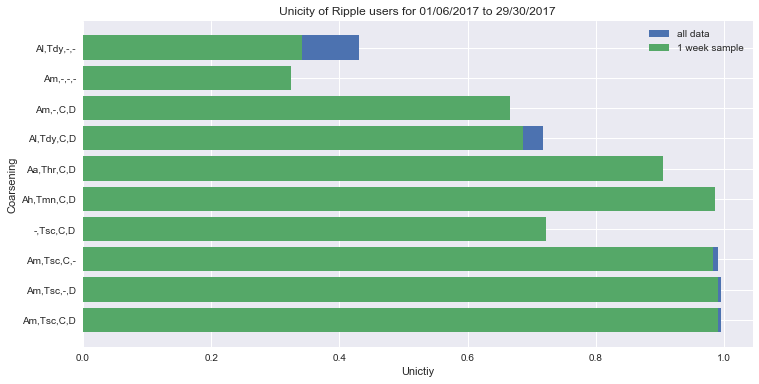

In [34]:
plt.figure(figsize=(12,6))
font={'family': 'arial',
     'size': 40}
plt.title('Unicity of Ripple users for 01/06/2017 to 29/30/2017')
plt.barh(range(len(results_p1)),list(results_p1.values()),tick_label=list(results_p1.keys()),label='all data')
plt.barh(range(len(results_p1_sample)),list(results_p1_sample.values()),tick_label=list(results_p1_sample.keys()),label='1 week sample')
plt.legend()
plt.ylabel('Coarsening')
plt.xlabel('Unictiy')
plt.rc('font',**font)

#<- Apologies about the overlapping bar plots, currently working on these

Compare with figure from paper:
![](DiLuzioMeiStefa_results.png)

# Analysis
In progress

1. Investigating discrepancies between the results calculated here and the results of the paper

In [45]:
# - Tsc C D
'''
Paper: "drops to 89.86%"
'''
def by_time(data_by_sender):
    '''Convert dictionary of type {sender: {datapoint1,datapoint2...}} to one of type {time: {sender1,sender3,...}}'''
    data_by_time = {}
    for sender in data_by_sender:
        for datapoint in data_by_sender[sender]:
            time = datapoint[2]
            if time not in data_by_time:
                data_by_time[time] = set()
            data_by_time[time].add(sender)
    return data_by_time
data_by_sender = pickle.load(open('-,Tsc,C,D_p1-data_by_sender.pkl','rb'))
users_by_time = by_time(data_by_sender)

>Maybe somehow the transactions come in batches?

In [44]:
#Manipulate data
dict_sample(users_by_time)

[('2017-08-08T02:21:50', {'rLSQVWfU2ZzCyRTKXUa6oHKbQ225uVrwD1'}),
 ('2017-07-30T16:07:00', {'rG7QZMnX2uQPFfvozpd1iEjZY64J55Q6pE'})]

In [41]:
maxm = 0
peak_time = ''
data_by_time_agg = {}
for time in users_by_time.keys():
    data_by_time_agg[time] = len(users_by_time[time])
    count = len(users_by_time[time])
    if count > maxm:
        maxm = count
        peak_time = time

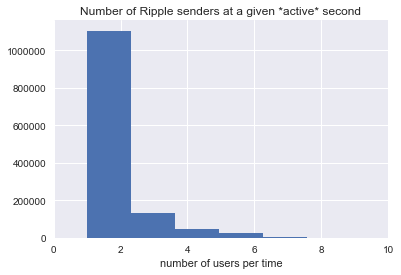

In [42]:
plt.figure()
plt.title("Number of Ripple senders at a given *active* second")
hist = plt.hist(list(data_by_time_agg.values()),bins=57)
plt.xlim([0,10])
plt.xlabel('number of users per time')

In [43]:
print("Number of active seconds during which there is only one sender recorded as having made a transaction:",hist[0][0])
print(hist[0][0]/len(data_by_time_agg))

Number of active seconds during which there is only one sender recorded as having made a transaction: 1103434.0
0.838249560339


Previously, when analysing 1 week of data, the number of active seconds during which there is only one sender recorded as having made a transaction was 56529.0, or 53.2%